In [29]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Set random seed for reproducibility
torch.manual_seed(44)
np.random.seed(44)


class VanGenuchten:
    def __init__(self, theta_s, theta_r, alpha, n, Ks, l):
        self.theta_s, self.theta_r = theta_s, theta_r
        self.alpha, self.n, self.m = alpha, n, 1.0 - 1.0 / n
        self.Ks, self.l = Ks, l
        self._tiny = 1e-12  # minimal guard

    def theta(self, h):
        abs_h = torch.abs(h)
        denom = (1.0 + (self.alpha * abs_h).pow(self.n)).pow(self.m)
        denom = denom + self._tiny  # avoid 0
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(
            h >= 0.0,
            torch.as_tensor(self.theta_s, device=h.device, dtype=h.dtype),
            theta_unsat,
        )

    def Se(self, h):
        th = self.theta(h)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        # keep in (0,1) to avoid fractional-power NaNs
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h):
        Se = self.Se(h)
        Se_1m = Se.pow(1.0 / self.m)
        K_unsat = self.Ks * (Se.pow(self.l)) * (1.0 - (1.0 - Se_1m).pow(self.m)).pow(2)
        return torch.where(
            h >= 0.0,
            torch.as_tensor(self.Ks, device=h.device, dtype=h.dtype),
            torch.clamp(K_unsat, 0.0, self.Ks),
        )  # keep nonnegative & ≤ Ks


class PressureHeadNet(nn.Module):
    """Neural network for pressure head h(z,t)"""

    def __init__(self, hidden_dim, num_layers):
        super().__init__()

        layers = []
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        inputs = torch.cat([z, t], dim=1)
        h = self.net(inputs)
        # Constrain pressure head to reasonable range
        # return torch.clamp(h, -50.0, 5.0)
        return h


class RichardsPINN(nn.Module):
    """PINN for Richards equation with moving boundary"""

    def __init__(
        self, soil_params, q0_data, Sy, zr, h_net_config, zb_initial=1.5
    ):
        super().__init__()
        self.h_net = PressureHeadNet(
            h_net_config["hidden_dim"], h_net_config["num_layers"]
        )
        self.soil = VanGenuchten(**soil_params)
        self.Sy = torch.tensor(Sy, device=device)
        self.zr = zr  # Make this configurable instead of hardcoded 0.5
        self.zb_initial = zb_initial  # Initial water table depth
        self.q0_times = torch.tensor(q0_data[0], dtype=torch.float32, device=device)
        self.q0_values = torch.tensor(q0_data[1], dtype=torch.float32, device=device)

    def forward(self, z, t):
        """Return h(z,t) and z_b(t)"""
        h = self.h_net(z, t)
        return h

    def surface_flux(self, t):
        """Prescribed surface flux q0(t) - interpolated from input data"""
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)

        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= self.q0_times[0]:
                q0_interp[i] = self.q0_values[0]
            elif t_val >= self.q0_times[-1]:
                q0_interp[i] = self.q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(self.q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = self.q0_values[0]
                else:
                    t1, t2 = self.q0_times[idx - 1], self.q0_times[idx]
                    q1, q2 = self.q0_values[idx - 1], self.q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)

        return q0_interp.reshape_as(t)

    # Root uptake can be modified to include more complex root uptake functions
    def root_uptake(self, z, t):
        """Simple root uptake S(z,t) in the root zone"""
        S_max = 1e-7
        return torch.where(
            z >= -self.zr, torch.full_like(z, S_max), torch.zeros_like(z)
        )

    def compute_derivatives(self, h, z, t):
        """Raw autograd derivatives (no clipping)"""
        theta_h = self.soil.theta(h)
        dtheta_dt = torch.autograd.grad(theta_h.sum(), t, create_graph=True)[0]
        dh_dz = torch.autograd.grad(h.sum(), z, create_graph=True)[0]
        K_h = self.soil.K(h)
        q = -K_h * (dh_dz + 1.0)
        dq_dz = torch.autograd.grad(q.sum(), z, create_graph=True)[0]
        return dtheta_dt, dq_dz, q, K_h

    def pde_residual(self, z, t):
        """Richards equation: ∂θ/∂t = -∂q/∂z - S"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)
        h = self(z, t)
        dtheta_dt, dq_dz, _, _ = self.compute_derivatives(h, z, t)
        S = self.root_uptake(z, t)
        return dtheta_dt + dq_dz + S

    def surface_bc_residual(self, t):
        """Flux BC at z=0: q(0,t) = q0(t)"""
        t = t.requires_grad_(True)
        z0 = torch.zeros_like(t, requires_grad=True, device=t.device)
        h0= self(z0, t)
        K0 = self.soil.K(h0)
        dh_dz_0 = torch.autograd.grad(h0.sum(), z0, create_graph=True)[0]
        q_surf = -K0 * (dh_dz_0 + 1.0)
        q0 = self.surface_flux(t)
        return q_surf - q0



    def initial_conditions_residual(self, z, t0):
        """IC: hydrostatic guess h(z,t0)=z+z_b(t0), and z_b(t0)=zb_initial"""
        h = self(z, t0)
        h_ic = z + 1.5
        return (h - h_ic)

Using device: cpu


In [30]:
def train_pinn_original(
    soil_params,
    q0_data,
    Sy,
    zr,
    h_net_config,
    n_epochs=1000,
    learning_rate=1e-3,
    zb_initial=1.5,
):
    """
    Train the Richards PINN with adaptive z-domain and t-samples tied to q0_data.
    Now includes gradient monitoring for each loss component.

    Parameters:
    - soil_params: dict with VanGenuchten parameters
    - q0_data: [times, values] for surface recharge
    - Sy: specific yield
    - zr: rooting depth
    - h_net_config: {'hidden_dim': int, 'num_layers': int}
    - n_epochs: number of training epochs
    - learning_rate: optimizer learning rate
    - zb_initial: initial water table depth (default: 1.5 m)

    Returns:
        model, losses, comps, grads
    """

    # --- model & optimizer ---
    model = RichardsPINN(
        soil_params, q0_data, Sy, zr, h_net_config, zb_initial
    ).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- derive time bounds and helpers from q0_data ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(
        -1, 1
    )
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    def shuffled_q0_times():
        idx = torch.randperm(q0_times_t.shape[0], device=device)
        return q0_times_t[idx].clone()

    # Helper function to compute gradient norm for a loss term
    def compute_grad_norm(loss, model):
        """Compute the L2 norm of gradients for a specific loss term."""
        grads = torch.autograd.grad(
            loss,
            model.parameters(),
            retain_graph=True,
            create_graph=False,
            allow_unused=True,
        )
        grad_norm = 0.0
        for grad in grads:
            if grad is not None:
                grad_norm += grad.norm(2).item() ** 2
        return grad_norm**0.5

    # --- book-keeping ---
    losses = []
    comps = {
        "pde": [],
        "surf": [],
        "wt_head": [],
        "wt_kin": [],
        "ic_h": [],
        "ic_zb": [],
    }
    grads = {
        "pde": [],
        "surf": [],
        "wt_head": [],
        "wt_kin": [],
        "ic_h": [],
        "ic_zb": [],
        "total": [],
    }

    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(
        f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], z adaptive in [-z_b(t), 0]"
    )

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ===== Sample training points (adaptive domain) =====
        # (1) PDE collocation: use as many times as q0 has, shuffled each epoch
        t_col = shuffled_q0_times().requires_grad_(True)  # shape (N,1)



        # Sample z uniformly between -zb(t) and 0 for each t
        u_col = torch.rand_like(t_col)
        z_col = -1.5 * (1.0 - u_col) + z_max * u_col
        z_col = z_col.detach().requires_grad_(True)  # z needs grads for PDE residual

        # (2) Boundary (surface flux at z=0): times aligned to q0 support & count
        t_bc = shuffled_q0_times().requires_grad_(True)

        # (3) Initial condition (at t = t_min): match count to q0 length
        t_ic = torch.full_like(q0_times_t, t_min)  # no grads needed for IC time
        u_ic = torch.rand_like(t_ic)
        z_ic = -1.5 * (1.0 - u_ic) + z_max * u_ic  # IC z samples in [-zb(t_min), 0]

        # ===== Compute residuals =====
        # PDE residual on interior points
        res_pde = model.pde_residual(z_col, t_col)  # (N,1)
        loss_pde = (res_pde**2).mean() 

        # Surface flux BC at z=0
        res_surf = model.surface_bc_residual(t_bc)  # (N,1)
        loss_surf = (res_surf**2).mean() 

        # Initial conditions
        res_ic_h = model.initial_conditions_residual(z_ic, t_ic)
        loss_ic_h = (res_ic_h**2).mean()


        # ===== Compute gradients for each loss component =====
        grad_pde = compute_grad_norm(loss_pde, model)
        grad_surf = compute_grad_norm(loss_surf, model)
        grad_ic_h = compute_grad_norm(loss_ic_h, model)

        # ===== Total loss with scaling to handle magnitude differences =====
        # Scale up small losses so they contribute to training
        total_loss = (
            loss_pde  # PDE is ~1e-14, scale up
            + loss_surf  # Surface BC is ~1e-10, scale up significantly
            + loss_ic_h  # Already ~1e-2
        )

        # ===== Backprop + step =====
        total_loss.backward()

        # Compute total gradient norm after backward pass
        total_grad_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm(2).item() ** 2
        total_grad_norm = total_grad_norm**0.5

        optimizer.step()

        # ===== Logging =====
        losses.append(total_loss.item())
        comps["pde"].append(loss_pde.item())
        comps["surf"].append(loss_surf.item())
        comps["ic_h"].append(loss_ic_h.item())

        # Store gradients
        grads["pde"].append(grad_pde)
        grads["surf"].append(grad_surf)
        grads["ic_h"].append(grad_ic_h)
        grads["total"].append(total_grad_norm)

        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(f"\n[{epoch+1:4d}/{n_epochs}]")
            print(f"  Losses: total={total_loss.item():.3e}")
            print(f"    PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}")
            print(f"  Gradients (L2 norm):")
            print(f"    PDE={grad_pde:.3e}, Surf={grad_surf:.3e}")
            print(f"    Total={total_grad_norm:.3e}")

    print("\nTraining done.")
    print(f"Final gradient norms: Total={total_grad_norm:.3e}")
    return model, losses, comps

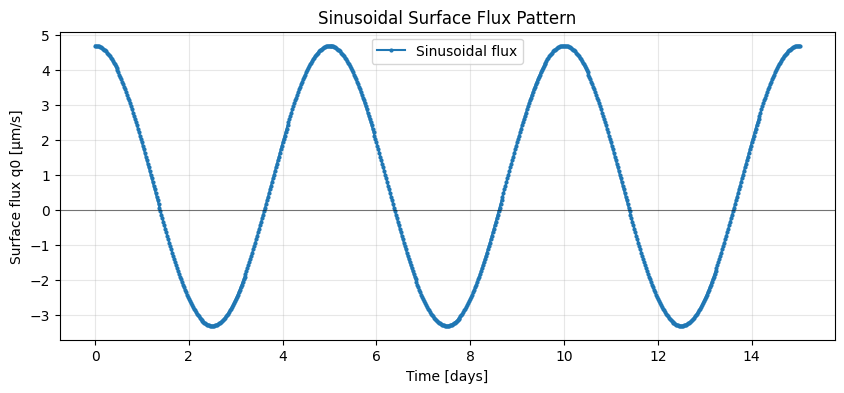

Flux range: -3.30 to 4.70 μm/s
Period: 5 days, Total duration: 15 days


In [31]:
def create_sinusoidal_qflux(
    total_days=15,
    dt_minutes=30,
    amplitude=4e-6,
    period_days=5,
    mean_flux=1e-7,
    phase_shift=0,
):
    """
    Create sinusoidal surface flux pattern

    Parameters:
    - total_days: simulation duration
    - dt_minutes: time step in minutes
    - amplitude: amplitude of oscillation [m/s]
    - period_days: period of oscillation in days
    - mean_flux: mean flux level [m/s] (positive = evaporation, negative = infiltration)
    - phase_shift: phase shift in radians
    """
    dt_days = dt_minutes / (24 * 60)
    times = np.arange(0, total_days + dt_days, dt_days)

    # Sinusoidal flux: q(t) = mean + amplitude * sin(2π*t/period + phase)
    omega = 2 * np.pi / period_days  # angular frequency
    qflux = mean_flux + amplitude * np.sin(omega * times + phase_shift)

    return times, qflux


# Create sinusoidal q0_data
times_sin, qflux_sin = create_sinusoidal_qflux(
    total_days=15,
    amplitude=4e-6,  # 3 μm/s amplitude
    period_days=5,  # 5-day cycle
    mean_flux=7e-7,  # slight evaporation on average
    phase_shift=np.pi / 2,  # start at peak
)
qflux_sin = qflux_sin
q0_data_sin = (times_sin.tolist(), qflux_sin.tolist())

# Plot the sinusoidal flux
plt.figure(figsize=(10, 4))
plt.plot(times_sin, qflux_sin * 1e6, "-o", ms=2, label="Sinusoidal flux")
plt.axhline(0, color="k", lw=0.8, alpha=0.5)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [μm/s]")
plt.title("Sinusoidal Surface Flux Pattern")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Flux range: {qflux_sin.min()*1e6:.2f} to {qflux_sin.max()*1e6:.2f} μm/s")
print(f"Period: {5} days, Total duration: {15} days")

In [32]:
soil_params = {
    "theta_s": 0.4,
    "theta_r": 0.1,
    "alpha": 0.01,
    "n": 1.3,
    "Ks": 1e-5,
    "l": 0.5,
}
# Define network configurations
h_net_config = {"hidden_dim": 64, "num_layers": 4}

# Or specify custom initial depth
model, losses, comps = train_pinn_original(
    soil_params=soil_params,
    q0_data=q0_data_sin,
    Sy=0.1,
    zr=0.5,
    h_net_config=h_net_config,
    n_epochs=2000,
    learning_rate=1e-3,
    zb_initial=1.0,  # 2m initial water table depth
)

Training for 2000 epochs | lr=0.001
Time domain from q0: t∈[0.000, 15.021], z adaptive in [-z_b(t), 0]

[   1/2000]
  Losses: total=6.118e-01
    PDE=7.351e-15, Surf=1.228e-10
  Gradients (L2 norm):
    PDE=1.496e-13, Surf=7.717e-11
    Total=2.209e+00

[ 200/2000]
  Losses: total=1.905e-04
    PDE=1.581e-10, Surf=1.352e-10
  Gradients (L2 norm):
    PDE=3.656e-09, Surf=2.746e-10
    Total=4.793e-03

[ 400/2000]
  Losses: total=1.103e-04
    PDE=1.438e-10, Surf=1.388e-10
  Gradients (L2 norm):
    PDE=1.482e-09, Surf=2.974e-10
    Total=5.019e-03

[ 600/2000]
  Losses: total=8.827e-05
    PDE=1.285e-10, Surf=1.402e-10
  Gradients (L2 norm):
    PDE=1.049e-09, Surf=3.061e-10
    Total=9.745e-04

[ 800/2000]
  Losses: total=5.981e-05
    PDE=1.807e-10, Surf=1.418e-10
  Gradients (L2 norm):
    PDE=6.740e-09, Surf=3.158e-10
    Total=3.588e-03

[1000/2000]
  Losses: total=4.321e-05
    PDE=1.359e-10, Surf=1.432e-10
  Gradients (L2 norm):
    PDE=1.766e-09, Surf=3.249e-10
    Total=9.578e-

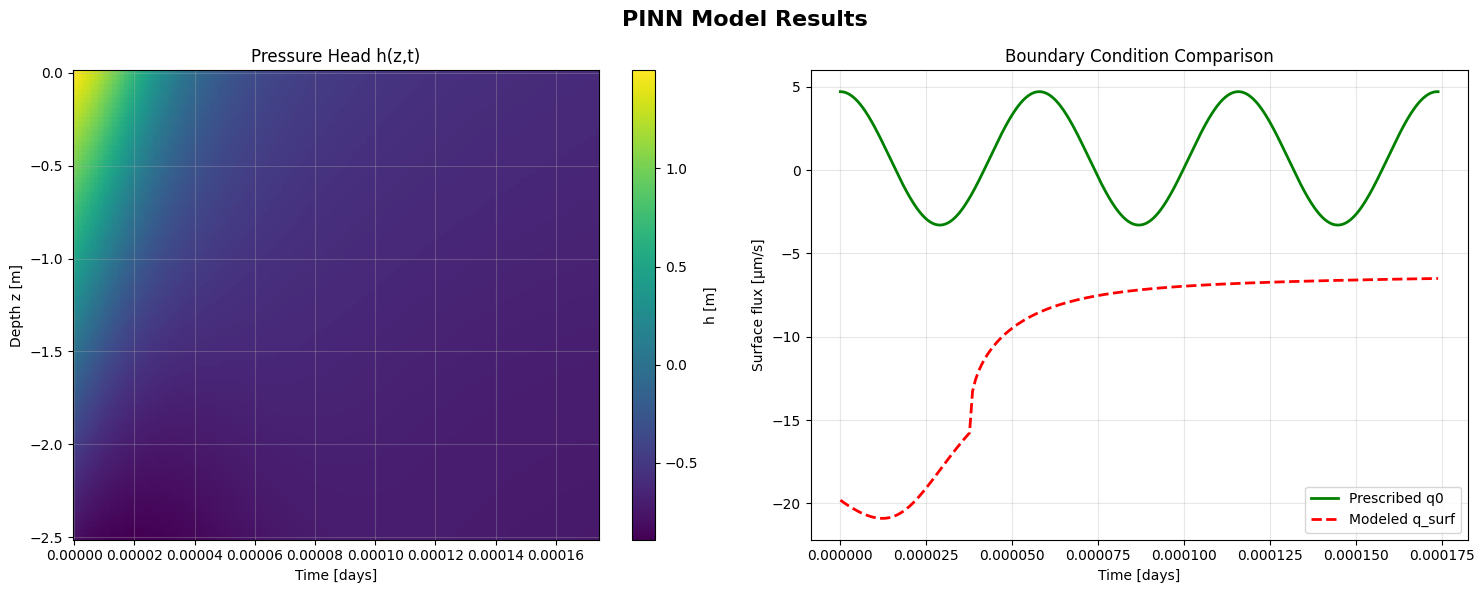


Model Performance:
Surface flux MSE: 1.48e-10 m²/s²
Surface flux RMSE: 12.18 μm/s


In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_model_results(model, q0_data, n_t=200, n_z=100):
    """
    Plot key model results for dimensional PINN:
    1. 2D pressure head profile h(z,t)
    2. Time series comparison of prescribed vs modeled surface BC
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Time range from q0_data (already in seconds)
    t_min_s, t_max_s = float(min(q0_data[0])), float(max(q0_data[0]))
    t_lin_s = torch.linspace(t_min_s, t_max_s, n_t, device=device)
    t_lin_days = t_lin_s.detach().cpu().numpy() / 86400.0
    
    # For this dimensional model, assume water table depth around 1-2m
    z_min = -2.5  # meters
    z_max = 0.0   # surface
    z_lin_m = torch.linspace(z_min, z_max, n_z, device=device)
    
    # Create mesh for 2D plot
    Tm, Zm = torch.meshgrid(t_lin_s, z_lin_m, indexing="ij")
    
    # Compute h(z,t) directly (dimensional model)
    z_flat = Zm.reshape(-1, 1)
    t_flat = Tm.reshape(-1, 1)
    with torch.no_grad():
        h_flat = model.forward(z_flat, t_flat)
    H_grid = h_flat.reshape(Tm.shape).cpu().numpy()
    
    # Compute surface flux at z=0
    z_surf = torch.zeros((n_t, 1), device=device, requires_grad=True)
    t_surf = t_lin_s.view(-1, 1).requires_grad_(True)
    h_surf = model.forward(z_surf, t_surf)
    
    # Compute surface gradient
    dh_dz = torch.autograd.grad(h_surf.sum(), z_surf, create_graph=True)[0]
    
    # Surface hydraulic conductivity
    K_surf = model.soil.K(h_surf)
    
    # Surface flux: q = -K * (dh/dz + 1)
    q_surf = -K_surf * (dh_dz + 1.0)
    q_surf_simulated = q_surf.detach().cpu().numpy().flatten()
    
    # Prescribed q0 data
    q0_t_days = np.array(q0_data[0]) / 86400.0
    q0_vals = np.array(q0_data[1])
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("PINN Model Results", fontsize=16, fontweight="bold")
    
    # 1. 2D Pressure Head Profile
    im = ax1.pcolormesh(
        t_lin_days, z_lin_m.cpu().numpy(), H_grid.T, 
        shading="auto", cmap="viridis"
    )
    ax1.set_xlabel("Time [days]")
    ax1.set_ylabel("Depth z [m]")
    ax1.set_title("Pressure Head h(z,t)")
    ax1.grid(True, alpha=0.3)
    plt.colorbar(im, ax=ax1, label="h [m]")
    
    # 2. Surface BC Comparison (Time Series)
    ax2.plot(q0_t_days, q0_vals * 1e6, "g-", lw=2, label="Prescribed q0")
    ax2.plot(t_lin_days, q_surf_simulated * 1e6, "r--", lw=2, label="Modeled q_surf")
    ax2.set_xlabel("Time [days]")
    ax2.set_ylabel("Surface flux [μm/s]")
    ax2.set_title("Boundary Condition Comparison")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print model performance
    flux_error = np.mean((q_surf_simulated - np.interp(t_lin_days, q0_t_days, q0_vals))**2)
    print(f"\nModel Performance:")
    print(f"Surface flux MSE: {flux_error:.2e} m²/s²")
    print(f"Surface flux RMSE: {np.sqrt(flux_error)*1e6:.2f} μm/s")

# Plot the model results
plot_model_results(model, q0_data_sin)
